<table><tbody><tr><th><p><img alt="Emblema" src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" style="width:150px;"></p></th><th><p><strong>Inteligencia Artificial</strong></p><p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p><p><strong>TRABAJO IA</strong></p><h1>Machine Learning - Regresión Lineal Multivariable</h1></th></tr></tbody></table>


In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns

### Análisis de los datos
El conjunto de datos está enfocado a la predicción del coste del seguro médico, y nos brinda 54 características con las que operar.

En ésta página web podremos ver en profundidad qué representan las distintas características.

En resumen, éstas pueden condensarse en 6 grupos:

1. Demográficas y Socioeconómicas.
2. Estilo de vida y hábitos.
3. Salud y datos clínicos.
4. Uso del seguro médico y procedimientos utilizados.
5. Seguro y Políticas.
6. Costes médicos y pagos.

Carguemos los datos y echémosles un vistazo:

In [2]:
#Funcion para leer los datos
def read_csv(file_name):
    try:
        df = pd.read_csv(file_name)
        return df
    except FileNotFoundError:
        print(f"ERROR: El archivo '{file_name}' no se encuentra.")
        return None

In [3]:
#Llamamos a la funcion para cargar nuestro csv personalizado
df = read_csv('medical_insurance.csv')
#Comprobamos que se ha cargado bien
df.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


In [4]:
# Quitar espacios al inicio y fin de los nombres de columna para no haber fallos en en la programacion 
df.columns = df.columns.str.strip()

### Preparacion de los datos

## Variables categóricas
Las variables categóricas han de pasarse a numéricas. Para ello, podemos usar dos métodos:

Label encoding: Cambiamos cada tipo de valor por un número entero. Para valores que tengan relación y cierta continuidad, tendría sentido usar ésta opción, ya que implícitamente se crea una relación mayor-menor entre los valores. Ej.: Frecuencia de uso de alcohol -> ['Occasional' -> 1, 'Weekly' -> 2, 'Daily' -> 3]

One-hot encoding: Se crea, por cada valor único de la tabla, una nueva columna binaria. En ellas se pondría un 0 o un 1 dependiendo del valor de la fila original. Ésto, en contraste con el label encoding, no crea un orden intrínseco para los valores de la columna. Sería ideal, por ejemplo, para la columna región, que tiene como valores únicos norte, sur, este y oeste (no hay orden aquí, ej.: sur no es "menor" que norte).

Teniendo en cuenta ambos métodos, vamos a realizar la conversión:

In [5]:
# Label encoding

# Tenemos que crear unos "mapas" mediante los cuales
# le asignaremos valores numéricos a los distintos
# valores de cada columna.

# La educación la ordenaremos de menor a mayor formación
education_map = {
    'No HS': 0, 'HS': 1, 'Some College': 2,
    'Bachelors': 3, 'Masters': 4, 'Doctorate': 5
}

# Ésta variable podría ser codificada mediante otras técnicas
# pero me ha parecido interesante repartirla así
smoker_map = {
    'Never': 0, 'Former': 1, 'Current': 2
}

# Ordenamos según la frecuencia
alcohol_map = {
    'None': 0, 'Occasional': 1, 'Weekly': 2, 'Daily': 3
}

# Ordenamos por rango, de peor a mejor.
tier_map = {
    'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3
}

# Aplicamos los cambios
df['education_encoded'] = df['education'].map(education_map)
df['smoker_encoded'] = df['smoker'].map(smoker_map)
df['alcohol_freq_encoded'] = df['alcohol_freq'].map(alcohol_map)
df['network_tier_encoded'] = df['network_tier'].map(tier_map)

# get_dummies no borra las columnas originales, así que tenemos que hacerlo nosotros.
df.drop(columns=['education', 'smoker', 'alcohol_freq', 'network_tier'], inplace=True)

df.head()
print(df.columns)

Index(['person_id', 'age', 'sex', 'region', 'urban_rural', 'income',
       'marital_status', 'employment_status', 'household_size', 'dependents',
       'bmi', 'visits_last_year', 'hospitalizations_last_3yrs',
       'days_hospitalized_last_3yrs', 'medication_count', 'systolic_bp',
       'diastolic_bp', 'ldl', 'hba1c', 'plan_type', 'deductible', 'copay',
       'policy_term_years', 'policy_changes_last_2yrs', 'provider_quality',
       'risk_score', 'annual_medical_cost', 'annual_premium',
       'monthly_premium', 'claims_count', 'avg_claim_amount',
       'total_claims_paid', 'chronic_count', 'hypertension', 'diabetes',
       'asthma', 'copd', 'cardiovascular_disease', 'cancer_history',
       'kidney_disease', 'liver_disease', 'arthritis', 'mental_health',
       'proc_imaging_count', 'proc_surgery_count', 'proc_physio_count',
       'proc_consult_count', 'proc_lab_count', 'is_high_risk',
       'had_major_procedure', 'education_encoded', 'smoker_encoded',
       'alcohol_freq_en

In [6]:
# One-Hot Encoding

# El one-hot es mucho más sencillo si hacemos uso de get_dummies,
# ya que lo hace automáticamente. Pero primero, tenemos que indicarle
# sobre qué columnas queremos el onehot:
nominal_cols = [
    'sex', 'region', 'urban_rural', 
    'marital_status', 'employment_status', 'plan_type'
]

# IMPORTANTE: Si no le ponemos el dtype=int, en vez de devolver 0 o 1, devolverá
# true o false. Para el modelo de regresión logística, que al fin y al cabo
# no son más que un conjunto de fórmulas matemáticas, necesitamos el
# valor numérico para poder operar.
df = pd.get_dummies(df, columns=nominal_cols, dtype=int)

# Vemos el resultado
df.head()

,person_id,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,...,marital_status_Single,marital_status_Widowed,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Unemployed,plan_type_EPO,plan_type_HMO,plan_type_POS,plan_type_PPO
0,75722,52,22700.0,3,1,27.4,2,0,0,4,...,0,0,0,1,0,0,0,0,0,1
1,80185,79,12800.0,3,1,26.6,2,0,0,3,...,0,0,1,0,0,0,0,0,1,0
2,19865,68,40700.0,5,3,31.5,1,0,0,4,...,0,0,0,1,0,0,0,1,0,0
3,76700,15,15600.0,5,3,31.6,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,92992,53,89600.0,2,0,30.5,3,0,0,2,...,0,0,0,0,1,0,0,0,1,0


<h1>Correlacion</h1><hr>


In [7]:
#Para saber cuales son las variables dependientes/predictoras (X) sobre la variable 'TARGET' (Y), recurrimos a la CORRELACIÓN

#Como variable objetivo, he pensado en utilizar la columna 'annual_medical_cost' (variable numerica y continua) que aporta informacion sobre
#los gastos anuales destinados al campo medico que tiene cada persona (estudio imprescindible en este dataset para este algoritmo).

#Inicialiazamos esa col como objetivo:
target_col = 'annual_medical_cost'

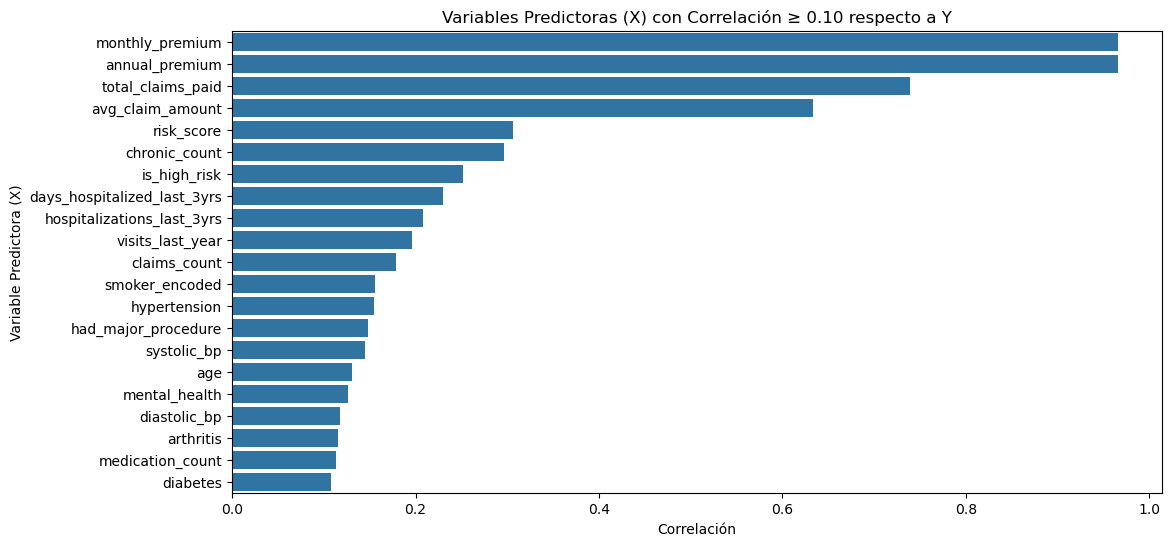

Lista de Variables X a usar:
['monthly_premium', 'annual_premium', 'total_claims_paid', 'avg_claim_amount', 'risk_score', 'chronic_count', 'is_high_risk', 'days_hospitalized_last_3yrs', 'hospitalizations_last_3yrs', 'visits_last_year', 'claims_count', 'smoker_encoded', 'hypertension', 'had_major_procedure', 'systolic_bp', 'age', 'mental_health', 'diastolic_bp', 'arthritis', 'medication_count', 'diabetes']


In [19]:
def correlacion_var(df,target_col,umbral_minimo):
    #Matriz de relaciones lineales entre variables
    correlaciones = df.corr()
    target_lista = correlaciones[target_col].abs().sort_values(ascending=False)
    
    # Filtrar solo las que cumplan la condicion del umbral
    lista_filtrada = target_lista.drop(target_col)
    lista_relevante = lista_filtrada[lista_filtrada >= umbral_minimo]
    
    #Visualizar que relacion tiene cada var con 'TARGET'
    plt.figure(figsize=(12,6)) 
    sns.barplot(x=lista_relevante.values, y=lista_relevante.index,legend='auto')
    
    plt.title(f'Variables Predictoras (X) con Correlación ≥ {umbral_minimo:.2f} respecto a Y')
    plt.xlabel('Correlación')
    plt.ylabel('Variable Predictora (X)')
    plt.show()
    
    print("Lista de Variables X a usar:")
    print(lista_relevante.index.tolist())


#Llamamos a la funcion para ver si se ha implementado bien
correlacion_var(df,target_col,umbral_minimo=0.10)
    
    
  

### Normalización y estandarización
Para empezar, las columnas a normalizar serán, por lo general, aquellas que no se pretendan predecir. Es decir, si estoy intentando predecir el coste anual del seguro médico, no voy a normalizar dicha columna; en cambio, si estoy usando el coste anual para predecir otra cosa, ahí si consideraré su normalización.

También, por lo general, deberíamos de normalizar todos los campos numéricos para mantener una magnitud similar, sobretodo en aquellos campos donde las magnitudes sean especialmente dispares.

Sin embargo, hay casos donde podría no ser la mejor opción:

Campos "Binarios": Aquellos campos cuyos valores sean únicamente 1 y 0 no se normalizan. De hecho, en caso de hacerlo, sus valores no cambiarían.
Campos discretos con baja magnitud: Por ejemplo, en campos como visits_last_year, normalizarlos no tiene sentido, ya que sus valores no suelen cambiar de magnitud de uno a otro, ni tenemos valores intermedios.
Por lo tanto, valores como la presión sistólica, el ingreso, el coste anual, etc podrían ser buenos candidatos para ser normalizados. Teniendo eso en cuenta, vamos a proceder a normalizar usando la fórmula del Z-Score:

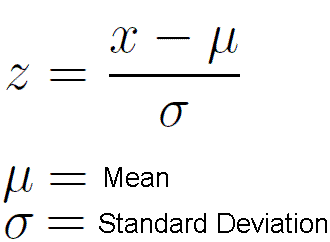

In [ ]:
# Lista de columnas continuas a normalizar
columnasNormalizar = [
    'age', 'income', 'bmi', 'visits_last_year', 'days_hospitalized_last_3yrs', 'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c', 
    'deductible', 'copay', 'annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'total_claims_paid'
]

# Aplicamos la fórmula del z-score: (valor - media) / desviacionEstandar
#
# Si lo hacemos de la siguiente manera, estaremos usando la vectorización que usa pandas por dentro,
# por lo que ésta operación se vuelve bastante más ligera
df[columnasNormalizar] = (df[columnasNormalizar] - df[columnasNormalizar].mean()) / df[columnasNormalizar].std()

# Comprobamos los datos
df.head()

## Implementación
Ahora, pasaremos a implementar el algoritmo de regresión lineal. Este algoritmo está diseñado para predecir valores continuos y numéricos.
En nuestro caso, queremos precedir el coste anual por persona en el ambito médico según las distintas instancias del conjunto.

Para ello, primero inicializaremos las funciones necesarias.

## Funciones

##### Hipotesis del modelo de regresion lineal multivariable
Siendo n el número de variables/atributos del dataset:
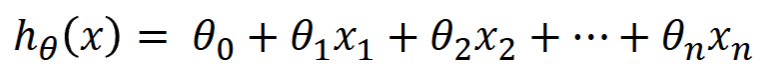

##### Funcion de coste
Es el Error Cuadrático. El objetivo de la regresión lineal es minimizar el coste de la función.
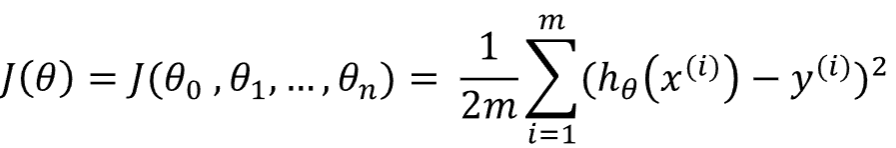

In [ ]:
def funcion_coste(X, y, theta):
    """Calcula el Coste J (Error Cuadrático Medio)."""
    m = len(y)
    h = np.dot(X, theta)  # Hipótesis: h(x) = X * theta
    error = h - y
    J = (1 / (2 * m)) * np.sum(error**2)
    return J


##### Descenso del Gradiente
Algoritmo de optimización que se usa para encontrar el valor mínimo de una función de manera iterativa, minimizando los errores de un modelo de aprendizaje automático al ajustar sus parámetros.
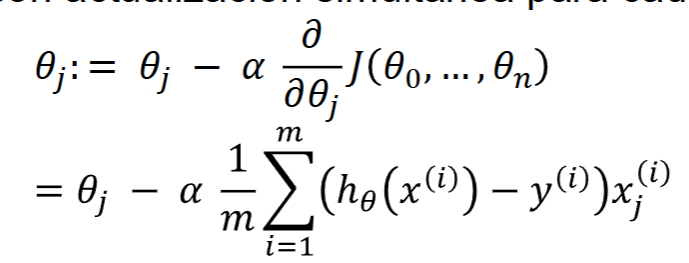

In [ ]:
def descenso_gradiente(X, y, theta, alpha, num_iters):
    """Ajusta theta para minimizar el coste J."""
    m = len(y)
    J_history = []
    
    for i in range(num_iters):
        h = np.dot(X, theta)
        
        # Cálculo del gradiente: (1/m) * Transpuesta(X) * (h - y)
        gradient = (1/m) * np.dot(X.T, (h - y))
        
        # Actualización de theta
        theta = theta - (alpha * gradient)
        
        J_history.append(funcion_coste(X, y, theta))
        
    return theta, J_history

In [ ]:
alpha = 0.1       # Tasa de aprendizaje
num_iters = 1500  # Número de iteraciones
theta_init = np.zeros(X_ready.shape[1]) # Inicializamos Theta

print("Entrenando modelo manual por Descenso del Gradiente...")
theta_final, J_history = descenso_gradiente(X_ready, y_data, theta_init, alpha, num_iters)

print(f"\nParámetros Theta Finales (Manual): {theta_final}")
print(f"Coste Mínimo alcanzado (J): {J_history[-1]:.2f}")

# 6.4. Gráfica de Convergencia
plt.plot(J_history, color='red')
plt.title('Curva de Aprendizaje: Convergencia del Coste J')
plt.xlabel('Iteraciones')
plt.ylabel('Coste J')
plt.grid(True)
plt.show()